Выполнил задание в google colaboratory, так как при обучении нейронки в jupyter у меня не работает gpu(а времени ждать 5 часов у меня не оставалось), потому что памяти видеокарты не хватает, я не знаю, пытался уменшить батчи - не помогло, может быть проблема еще в библиотеках(не сочетаются друг с другом). Простите..

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import nltk

In [2]:
path_test_spam = '/content/drive/MyDrive/Стажировки/VK ML/test_spam.csv'
path_train = '/content/drive/MyDrive/Стажировки/VK ML/train_spam.csv'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv(path_train)

In [5]:
df.shape

(16278, 2)

In [6]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


Проверяем есть ли пустые значения

In [8]:
df.isnull().any()

text_type    False
text         False
dtype: bool

Посмотрим на целевой признак

In [9]:
df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

Проверим на дубликаты

In [10]:
df.duplicated().sum()

11

Уберем дубликаты

In [11]:
df.drop_duplicates(keep='first', inplace = True)

Построим «облако слов» для набора данных, чтобы визуально определить наиболее часто встречающиеся слова – это позволит оценить необходимость дополнительной очистки текстов от «мусора», не несущего смысловой нагрузки:



In [12]:
#Составляем корпус
corpus = []
for phrase in df.text:
    for word in phrase.split():
        corpus.append(word)

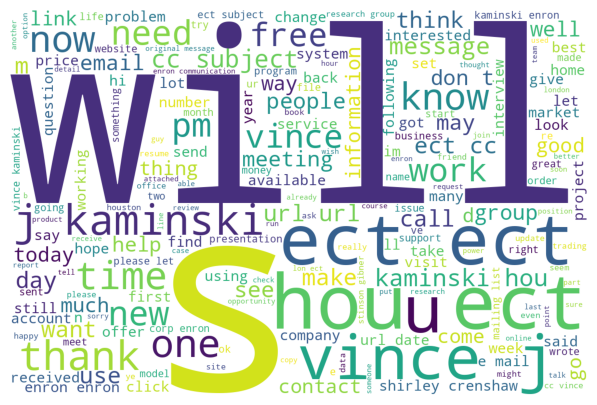

In [13]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

Cloud_text = ' '.join(corpus)
wordcloud = WordCloud( background_color = 'white',width=1200, height=800).generate(Cloud_text)
print(wordcloud)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

Попробуем очистить данные:

In [14]:
# функция которая убирает знаки пунктуации
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [15]:
# убираем знаки пунктуации и переводим в нижний регистр
df['text']=df['text'].astype('str')
df['text']= df['text'].apply(lambda x:remove_punctuation(x))
df['text']= df['text'].apply(lambda x:x.lower())

Можно еще убрать все числа, но как будто нет смысла

In [16]:
# стоп слова
nltk.download('stopwords')
stops = set(stopwords.words('english'))

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
#проверяем
print(df.text[100])

presenting wide range applications phone sms appstore 111 download fav application surfing charges 0p10kb apply


In [18]:
#Составляем корпус
corpus = []
for phrase in df.text:
    for word in phrase.split():
        corpus.append(word)

После небольшой очистки текстов от «стоп-слов» и знаков пунктуации «облако слов» стало более осмысленным:




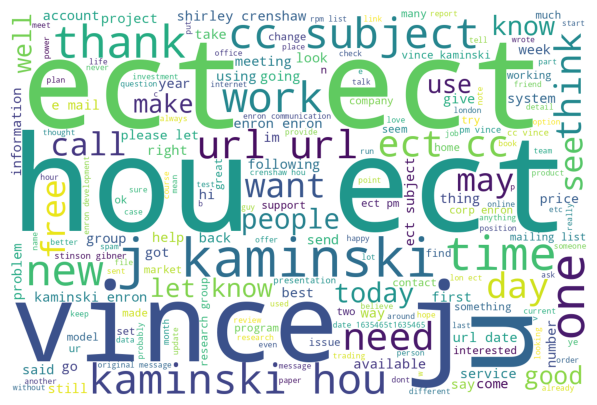

In [19]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

Cloud_text = ' '.join(corpus)
wordcloud2 = WordCloud( background_color = 'white',width=1200, height=800).generate(Cloud_text)


plt.imshow(wordcloud2)
plt.axis("off")

plt.show()

Покопался в интернете, ничего не нашел по словам hou, ect и vince j. Поэтому оставлю их.

Для целей классификации нам нужны числовые метки.


In [20]:
df['labels'] = df['text_type'].map({'ham': 0, 'spam': 1,})

Данные подготовлены, сначала воспользуемся FastText для векторизации текстов. Потом используем RandomForest, так как он подходит для не особо подготовленных данных, на интерес еще попробуем KNN и SVM

После этого возьмемся за дело всерьез. Воспользуемся BERT - гугловской нейросетью, которая решает много разных задач, перевод текстов, классификация текстов и другие.

## **FastText**

In [21]:
# Подготовка текстовых данных
from gensim.models import FastText
from gensim.utils import simple_preprocess

#Составляем корпус
corpus = np.array(df.text)

# Токенизируем
data = corpus
tokenized_data = [simple_preprocess(text) for text in data]

# Обучение модели FastText
model = FastText(vector_size=100, window=5, min_count=1, workers=4)
model.build_vocab(tokenized_data)
model.train(tokenized_data, total_examples=model.corpus_count, epochs=10)

(5018654, 5193900)

In [22]:
# Представляю данные в виде векторов

X = [model.wv[sentence] for sentence in df['text']]
Y = df.labels

In [23]:
# Делим на тренировочную и тестовую части
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score

In [25]:
# Случайный лес
rf = RandomForestClassifier(criterion='entropy').fit(X_train, y_train)

# предсказание
y_pred = rf.predict(X_test)

#roc auc
roc_auc = roc_auc_score(y_test, y_pred)
print("Roc Auc:", roc_auc)

Roc Auc: 0.8895396106330741


In [26]:
# Метод опорных векторов
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)

# предсказание
y_pred = svc.predict(X_test)

#roc auc
roc_auc = roc_auc_score(y_test, y_pred)
print("Roc Auc:", roc_auc)

Roc Auc: 0.892128088557884


In [27]:
# KNN
knn = KNeighborsClassifier().fit(X_train, y_train)

# предсказание
y_pred = knn.predict(X_test)

#roc auc
roc_auc = roc_auc_score(y_test, y_pred)
print("Roc Auc:", roc_auc)

Roc Auc: 0.8897819514753899


Roc Auc -0.9 - довольно неплохо. Посмотрим как себя покажет Bert

##BERT##

In [28]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=f718504f353e52f5ca024daed91c61acd3d4c0cc055bec0277494da96ec3fcea
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [29]:
sentences = np.array(df.text)
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [30]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [31]:
# Преобразим целевой признак в категориальный формат
y = tf.keras.utils.to_categorical(df["labels"].values, num_classes=2)
# Разобьем на тестовую и тренировочную части
X_train, X_test, y_train, y_test = train_test_split(df['text'],y, test_size=0.2, random_state=42)

Модели для предобработки

In [32]:
preprocess_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2'

In [33]:
bert_preprocess_url = hub.KerasLayer(preprocess_url)

#пример применения модели предобработки
text_preprocessed = bert_preprocess_url(["ordinarily discretion exercised costs follow"])
text_preprocessed.keys()

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])

In [34]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :16]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :16]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :16]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2030 18979 11272 19258 17747  5366  3582   102     0     0     0
     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
bert_model = hub.KerasLayer(encoder_url, trainable=True)

In [36]:
#пример
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {encoder_url}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.2188932  -0.03089423  0.09276239 -0.31189704  0.5293833  -0.9997566
 -0.33181083  0.96175414 -0.06745529  0.2543817  -0.0825948   0.901042  ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.24493125  0.15426217  0.00357777 ...  0.59421444 -0.37228897
  -0.56947607]
 [ 0.23072919  0.27920347 -0.46222165 ... -0.06779326 -0.38279533
  -0.27069336]
 [ 0.08721524  0.03800852  0.05849475 ...  0.9384289  -0.46570837
  -0.0040103 ]
 ...
 [ 0.00211674  0.37432656 -0.25642627 ...  0.1234597  -0.2793945
   0.16277236]
 [-0.04260855  0.26313898 -0.23433293 ...  0.21698163 -0.30860254
   0.16528018]
 [-0.23719746  0.32108277 -0.29195106 ...  0.25838435 -0.35044205
   0.03273007]]


Создадим и обучим классификационную модель



In [37]:
text_input = tf.keras.Input(shape = (), dtype = tf.string, name = 'text')
bert_preprocess = hub.KerasLayer(preprocess_url, name = 'preprocessing')
preprocessed_text = bert_preprocess(text_input)
bert_encoder = hub.KerasLayer(encoder_url, trainable = True, name = 'BERT_encoder')
outputs = bert_encoder(preprocessed_text)
net = outputs['pooled_output']

# l = tf.keras.layers.Dense(64, activation='relu')(outputs['pooled_output'])
# l = tf.keras.layers.Dropout(0.2)(l)
# l = tf.keras.layers.Dense(32, activation='relu')(l)
l = tf.keras.layers.Dropout(0.2)(outputs['pooled_output'])
l = tf.keras.layers.Dense(2, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

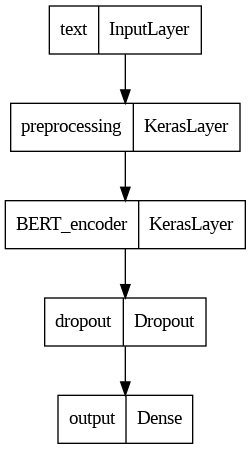

In [38]:
# структура модели
tf.keras.utils.plot_model(model)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [40]:
n_epochs = 6

METRICS = [ tf.keras.metrics.AUC(name='roc_auc')]

#checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_roc_auc",
                                                      patience = 3,
                                                      restore_best_weights = True)

In [41]:
loss = tf.keras.losses.BinaryCrossentropy()

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=loss,
              metrics=METRICS)

In [43]:
model_fit = model.fit(X_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/6
407/407 [==============================] - 475s 1000ms/step - loss: 0.1697 - roc_auc: 0.9819 - val_loss: 0.1025 - val_roc_auc: 0.9926
Epoch 2/6
381/407 [===========================>..] - ETA: 23s - loss: 0.0657 - roc_auc: 0.9961

KeyboardInterrupt: 

время поджимало поэтому вырубил на 2 эпохе, так как результат и так удовлетворительный

In [44]:
model.evaluate(X_test, y_test,batch_size=32)

102/102 [==============================] - 37s 358ms/step - loss: 0.1042 - roc_auc: 0.9920


[0.1042063906788826, 0.9920092821121216]

Оценка модели на тестовом наборе данных - 0.99. Я не знаю... наверное данные искуственные, поэтому такой результат. Я не делал тонкую настройку, да и структура модели простенькая.

Прогнозирование. Bert

In [45]:
model.predict(["i can smell one dark"])

1/1 [==============================] - 1s 825ms/step


array([[0.98963773, 0.01483961]], dtype=float32)

In [55]:
pred_test = pd.read_csv(path_test_spam)

In [ ]:
import csv


class_names = ["ham","spam"]
class_names[np.argmax(scores)]
# Data
texts = list(pred_test['text'])
data = [[text, class_names[np.argmax(model.predict([text]))]]for text in texts]
print(data)

In [82]:
# File path for the CSV file
csv_file_path = 'prediction.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)